In [ ]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sns
sns.set_style('whitegrid')
from collections import Counter
from sklearn import preprocessing
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
#from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/netflow_botnet


Mounted at /content/drive
/content/drive/MyDrive/netflow_botnet


In [ ]:
ctu_data = pd.read_csv('/content/drive/MyDrive/netflow_botnet/capture20110810.csv')

In [ ]:
ctu_data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/10 09:46:53.047277,3550.182373,udp,212.50.71.179,39678,<->,147.32.84.229,13363,CON,0.0,0.0,12,875,413,flow=Background-UDP-Established
1,2011/08/10 09:46:53.048843,0.000883,udp,84.13.246.132,28431,<->,147.32.84.229,13363,CON,0.0,0.0,2,135,75,flow=Background-UDP-Established
2,2011/08/10 09:46:53.049895,0.000326,tcp,217.163.21.35,80,<?>,147.32.86.194,2063,FA_A,0.0,0.0,2,120,60,flow=Background
3,2011/08/10 09:46:53.053771,0.056966,tcp,83.3.77.74,32882,<?>,147.32.85.5,21857,FA_FA,0.0,0.0,3,180,120,flow=Background
4,2011/08/10 09:46:53.053937,3427.768066,udp,74.89.223.204,21278,<->,147.32.84.229,13363,CON,0.0,0.0,42,2856,1596,flow=Background-UDP-Established


### EDA

In [ ]:
ctu_data.shape

(2824636, 15)

In [ ]:
ctu_data['Label'].value_counts()

flow=Background-UDP-Established                                            1169677
flow=To-Background-UDP-CVUT-DNS-Server                                      941706
flow=Background-TCP-Established                                             223543
flow=Background-Established-cmpgw-CVUT                                      137257
flow=Background-TCP-Attempt                                                 105438
                                                                            ...   
flow=From-Botnet-V42-TCP-Established-HTTP-Binary-Download-Custom-Port-5          1
flow=From-Botnet-V42-TCP-Established-HTTP-Ad-60                                  1
flow=From-Botnet-V42-TCP-Established-HTTP-Ad-49                                  1
flow=From-Botnet-V42-TCP-HTTP-Not-Encrypted-Down-2                               1
flow=From-Botnet-V42-TCP-Established-HTTP-Adobe-4                                1
Name: Label, Length: 113, dtype: int64

In [ ]:
ctu_data.info()

In [ ]:
ctu_data["Label"]

In [ ]:
no_of_label = ctu_data.Label.unique()
print(len(no_of_label))

Converting o/p into 3 labels :background-0 botnet-1 and Normal-2

In [ ]:
def Label_op(value):
    new_val = (value.split("=",1))[1]
    if "Background" in new_val:
        return 0
    elif "Botnet" in new_val:
        return 1
    else:
        return 2
    
#background-0 botnet-1 and Normal-2
ctu_data["Final-Labels"] = ctu_data.Label.apply(Label_op)
ctu_data["Final-Labels"].value_counts()

0    2753288
1      40961
2      30387
Name: Final-Labels, dtype: int64

In [ ]:
ctu_data.drop(['Label','Dir'],axis=1,inplace=True)

## EDA

Nan values correlations 

In [ ]:
nan_df = ctu_data[ctu_data.isnull().any(axis=1)]
nan_df.head(10)

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,Final-Labels
24,2011/08/10 09:46:53.107669,0.000000,tcp,199.59.148.20,443,?>,147.32.84.184,51855,A_,0.0,NaN,1,60,60,flow=Background,0
32,2011/08/10 09:46:53.132734,619.352722,udp,147.32.84.229,13363,->,31.9.113.254,23320,INT,0.0,NaN,4,568,568,flow=Background-UDP-Attempt,0
36,2011/08/10 09:46:53.138034,12.067851,tcp,178.236.4.29,80,?>,147.32.86.141,2019,FA_,0.0,NaN,3,180,180,flow=Background,0
49,2011/08/10 09:46:53.160043,0.000000,udp,147.32.80.9,53,->,147.32.86.111,54230,INT,0.0,NaN,1,141,141,flow=From-Normal-V42-UDP-CVUT-DNS-Server,2
52,2011/08/10 09:46:53.171249,12.067648,tcp,178.236.4.29,80,?>,147.32.86.141,2017,FA_,0.0,NaN,3,180,180,flow=Background,0
53,2011/08/10 09:46:53.174949,12.067688,tcp,178.236.4.29,80,?>,147.32.86.141,2016,FA_,0.0,NaN,3,180,180,flow=Background,0
56,2011/08/10 09:46:53.176116,25.455866,udp,147.32.84.229,13363,->,118.168.132.221,53663,INT,0.0,NaN,5,370,370,flow=Background-UDP-Attempt,0
115,2011/08/10 09:46:53.374594,6.035027,tcp,147.32.84.59,2289,->,151.64.186.190,6881,S_,0.0,NaN,2,124,124,flow=Background-Attempt-cmpgw-CVUT,0
119,2011/08/10 09:46:53.387846,3581.035645,pim,147.32.87.1,NaN,->,224.0.0.13,NaN,INT,0.0,NaN,182,13584,13584,flow=Background,0
136,2011/08/10 09:46:53.465909,724.939331,udp,147.32.84.229,13363,->,212.178.10.94,50239,INT,0.0,NaN,4,596,596,flow=Background-UDP-Attempt,0


In [ ]:
ctu_data.loc[ctu_data["Final-Labels"] == 1].shape[0]/ctu_data.shape[0]*100

1.4501337517471278

In [ ]:
nan_df['Final-Labels'].value_counts()

0    192287
1     12835
2       174
Name: Final-Labels, dtype: int64

In [ ]:
nan_df.shape[0]/ctu_data.shape[0]

0.07268051529471407

In [ ]:
nan_df.loc[nan_df["Final-Labels"] == 1].shape[0]

12835

In [ ]:
nan_df.loc[nan_df["Final-Labels"] == 1].shape[0]/ctu_data.shape[0]*100

0.4543948317588532

In [ ]:
(nan_df['Final-Labels'].value_counts()/ctu_data['Final-Labels'].value_counts()) *100

0     6.983904
1    31.334684
2     0.572613
Name: Final-Labels, dtype: float64

In [ ]:
nan_df['Proto'].value_counts()

udp          84447
tcp          80221
icmp         38153
igmp          1803
arp            477
rtcp            83
ipv6-icmp       58
ipx/spx         13
esp             10
ipv6            10
rtp              8
pim              7
rarp             4
unas             1
udt              1
Name: Proto, dtype: int64

In [ ]:
ctu_data['Proto'].value_counts()

udp          2270083
tcp           507557
icmp           39694
rtp             2570
rtcp            2339
igmp            1803
arp              477
ipv6-icmp         58
ipx/spx           13
esp               10
udt               10
ipv6              10
pim                7
rarp               4
unas               1
Name: Proto, dtype: int64

In [ ]:
(nan_df['Proto'].value_counts()/ctu_data['Proto'].value_counts())*100

arp          100.000000
esp          100.000000
icmp          96.117801
igmp         100.000000
ipv6         100.000000
ipv6-icmp    100.000000
ipx/spx      100.000000
pim          100.000000
rarp         100.000000
rtcp           3.548525
rtp            0.311284
tcp           15.805318
udp            3.719996
udt           10.000000
unas         100.000000
Name: Proto, dtype: float64

In [ ]:
nan_df['Proto']

Relation b/w botnet records and protocols

udp     29203
tcp     11756
icmp        2
Name: Proto, dtype: int64


(array([2.9203e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.1756e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

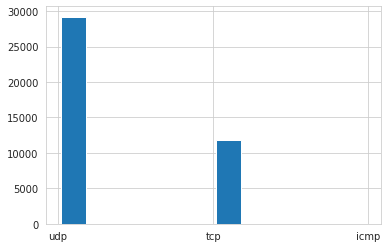

In [ ]:
botnet_df = ctu_data.loc[ctu_data["Final-Labels"] == 1]
print(botnet_df.Proto.value_counts())
plt.hist(botnet_df.Proto,histtype = 'bar',rwidth = 0.8)

Relation b/w background records and protocols

udp          2219883
tcp           486459
icmp           39657
rtp             2570
rtcp            2339
igmp            1803
arp              464
ipv6-icmp         58
ipx/spx           13
esp               10
ipv6              10
udt               10
pim                7
rarp               4
unas               1
Name: Proto, dtype: int64


(array([2.706342e+06, 2.570000e+03, 3.966400e+04, 4.640000e+02,
        1.300000e+01, 4.142000e+03, 5.800000e+01, 2.000000e+01,
        1.000000e+01, 5.000000e+00]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <a list of 10 Patch objects>)

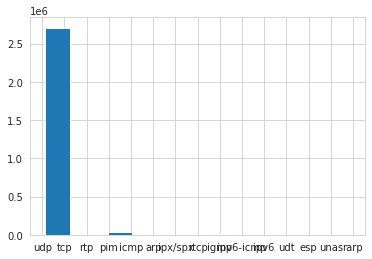

In [ ]:
background_df = ctu_data.loc[ctu_data["Final-Labels"] == 0]
print(background_df.Proto.value_counts())
plt.hist(background_df.Proto,histtype = 'bar',rwidth = 0.8)

Relation b/w sport and botnet

2077    16116
2079    12427
1025      239
1291      225
1303      201
        ...  
2843        1
2790        1
2327        1
1192        1
2301        1
Name: Sport, Length: 3975, dtype: int64


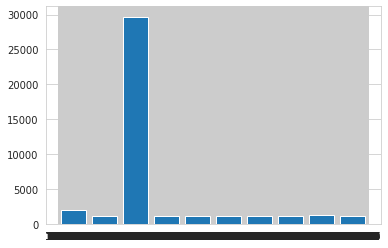

In [ ]:
plt.hist(botnet_df.Sport,histtype = 'bar',rwidth = 0.8)
print(botnet_df.Sport.value_counts())

In [ ]:
#plt.hist(np.int(background_df.Sport),histtype = 'bar',rwidth = 0.8)
print(background_df.Sport.value_counts())

13363     143098
0x0303     23559
12200      11115
80          5880
35155       5282
           ...  
799            1
481            1
951            1
85             1
222            1
Name: Sport, Length: 64734, dtype: int64


Relation between Src Addr, Botnet and Background traffic

In [ ]:
botnet_df.SrcAddr.value_counts()

147.32.84.165    40961
Name: SrcAddr, dtype: int64

In [ ]:
background_df.SrcAddr.value_counts()

147.32.84.138     530299
147.32.84.59      263081
147.32.84.229     143712
70.37.98.60        64001
147.32.85.25       44863
                   ...  
95.29.83.9             1
119.230.59.137         1
76.205.154.224         1
84.139.101.96          1
201.24.72.242          1
Name: SrcAddr, Length: 542087, dtype: int64

In [ ]:
background_df.head()

,StartTime,Dur,Proto,SrcAddr,Sport,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Final-Labels
0,2011/08/10 09:46:53.047277,3550.182373,udp,212.50.71.179,39678,147.32.84.229,13363,CON,0.0,0.0,12,875,413,0
1,2011/08/10 09:46:53.048843,0.000883,udp,84.13.246.132,28431,147.32.84.229,13363,CON,0.0,0.0,2,135,75,0
2,2011/08/10 09:46:53.049895,0.000326,tcp,217.163.21.35,80,147.32.86.194,2063,FA_A,0.0,0.0,2,120,60,0
3,2011/08/10 09:46:53.053771,0.056966,tcp,83.3.77.74,32882,147.32.85.5,21857,FA_FA,0.0,0.0,3,180,120,0
4,2011/08/10 09:46:53.053937,3427.768066,udp,74.89.223.204,21278,147.32.84.229,13363,CON,0.0,0.0,42,2856,1596,0


In [ ]:
background_df.loc[background_df['SrcAddr']=="95.29.83.9"].value_counts()

StartTime                   Dur       Proto  SrcAddr     Sport  DstAddr        Dport  State  sTos  dTos  TotPkts  TotBytes  SrcBytes  Final-Labels
2011/08/10 15:36:56.793895  0.000842  udp    95.29.83.9  57969  147.32.84.229  13363  CON    0.0   0.0   2        161       100       0               1
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


186     8990
142     5804
1430    1230
218      653
150      520
        ... 
888        1
531        1
167        1
1414       1
498        1
Name: TotBytes, Length: 602, dtype: int64


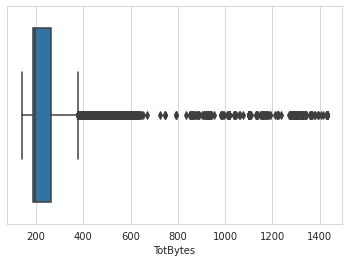

In [ ]:
#after removing outliers botnet TotBytes
sns.boxplot(botnet_df.TotBytes)
print(botnet_df.TotBytes.value_counts())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


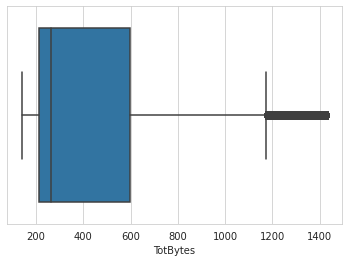

In [ ]:
#after removing outliers TotBytes for Background data
sns.boxplot(background_df['TotBytes'])

Plotting Totbytes together for botnet and background

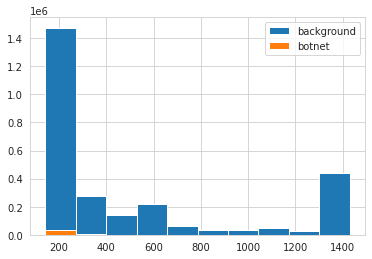

In [ ]:
plt.hist(background_df['TotBytes'],label='background')
plt.hist(botnet_df['TotBytes'],label='botnet')
plt.legend(loc='upper right')
plt.show()



(array([3.1469e+04, 4.6780e+03, 1.3430e+03, 1.8580e+03, 5.0000e+00,
        5.0000e+01, 1.0600e+02, 7.3000e+01, 7.9000e+01, 1.3000e+03]),
 array([ 142. ,  270.8,  399.6,  528.4,  657.2,  786. ,  914.8, 1043.6,
        1172.4, 1301.2, 1430. ]),
 <a list of 10 Patch objects>)

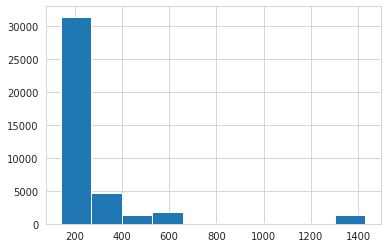

In [ ]:
plt.hist(botnet_df['TotBytes'],label='botnet')

Plotting Totpkts for both background and botnet

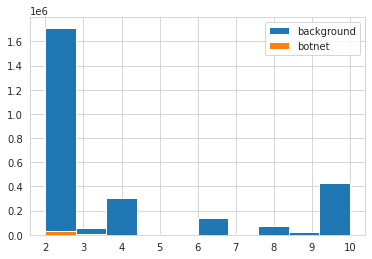

In [ ]:
plt.hist(background_df['TotPkts'],label='background')
plt.hist(botnet_df['TotPkts'],label='botnet')
plt.legend(loc='upper right')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


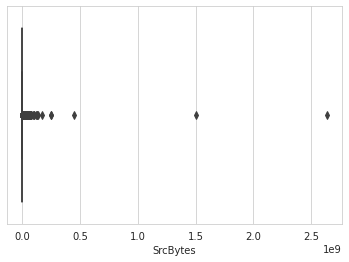

In [ ]:
sns.boxplot(ctu_data['SrcBytes'])

Missing values and percentages

In [ ]:
missing_counts = ctu_data.isnull().sum().sort_values(ascending=False)
missing_percent = ((ctu_data.isnull().sum()*100)/ctu_data.shape[0]).sort_values(ascending=False)
missing_df = pd.concat([missing_counts,missing_percent],axis=1,keys=['Counts','Percent'])
missing_df

,Counts,Percent
dTos,195190,6.910271
sTos,10590,0.374916
Sport,9379,0.332043
Dport,4390,0.155418
State,1,0.000035
Final-Labels,0,0.000000
SrcBytes,0,0.000000
TotBytes,0,0.000000
TotPkts,0,0.000000
DstAddr,0,0.000000


(array([2332053.,   33476.,   21007.,   32188.,   23350.,   48240.,
          67834.,   51508.,  127196.,   87671.]),
 array([   0.       ,  360.0031006,  720.0062012, 1080.0093018,
        1440.0124024, 1800.015503 , 2160.0186036, 2520.0217042,
        2880.0248048, 3240.0279054, 3600.031006 ]),
 <a list of 10 Patch objects>)

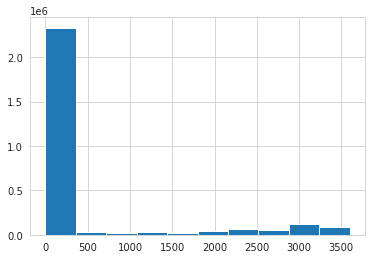

In [ ]:
plt.hist(ctu_data['Dur'])

In [ ]:
ctu_data.Dur.value_counts()

0.000000       79150
0.000252        4651
0.000246        4648
0.000251        4628
0.000242        4618
               ...  
2525.936768        1
24.709543          1
2721.057373        1
1836.412476        1
1881.653320        1
Name: Dur, Length: 1073189, dtype: int64

In [ ]:
ctu_data.Proto.value_counts()

udp          2270083
tcp           507557
icmp           39694
rtp             2570
rtcp            2339
igmp            1803
arp              477
ipv6-icmp         58
ipx/spx           13
ipv6              10
udt               10
esp               10
pim                7
rarp               4
unas               1
Name: Proto, dtype: int64

In [ ]:
num_of_pro = ctu_data.Proto.unique()
print(num_of_pro)
print(len(num_of_pro))

['udp' 'tcp' 'rtp' 'pim' 'icmp' 'arp' 'ipx/spx' 'rtcp' 'igmp' 'ipv6-icmp'
 'ipv6' 'udt' 'esp' 'unas' 'rarp']
15


In [ ]:
len(ctu_data.sTos.unique())

6

In [ ]:
ctu_data.sTos.value_counts()

0.0      2810723
2.0         1351
3.0          964
1.0          632
192.0        376
Name: sTos, dtype: int64

Plotting correlation between columns before extracting fields

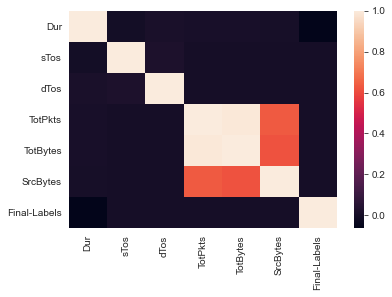

In [ ]:
sns.heatmap(ctu_data.corr())
plt.show()

## **Preprocessing**

Filling missing values

In [ ]:
ctu_data['sTos'] = ctu_data['sTos'].fillna(ctu_data['sTos'].mean())

In [ ]:
ctu_data['dTos'] = ctu_data['dTos'].fillna(ctu_data['dTos'].mean())

In [ ]:
ctu_data['State'].dropna(inplace=True,axis=0)

In [ ]:
ctu_data.groupby('Proto')['Dport'].count()

Proto
arp                0
esp               10
icmp           38377
igmp               0
ipv6               0
ipv6-icmp          0
ipx/spx            0
pim                0
rarp               0
rtcp            2339
rtp             2570
tcp           506882
udp          2270058
udt               10
unas               0
Name: Dport, dtype: int64

In [ ]:
reln_srcip = ctu_data.groupby('Dport',as_index=False)['SrcAddr'].count()
reln_srcip

,Dport,SrcAddr
0,0x0001,23
1,0x0002,4610
2,0x0003,96
3,0x0004,188
4,0x0005,5
...,...,...
73771,9995,9
73772,9996,2
73773,9997,7
73774,9998,5


In [ ]:
#filling dport based on dstip takes around 45mins to fill 
ctu_data['Dport'].fillna(ctu_data.groupby('DstAddr')['Dport'].apply(lambda x:x.mode())[0],inplace=True)
ctu_data['Sport'].fillna(ctu_data.groupby('SrcAddr')['Sport'].apply(lambda x:x.mode())[0],inplace=True)

In [ ]:
#faster filling but less corelation b/w proto and ports
ctu_data['Dport'].fillna(ctu_data.groupby('Proto')['Dport'].apply(lambda x:x.mode())[0],inplace=True)
ctu_data['Sport'].fillna(ctu_data.groupby('Proto')['Sport'].apply(lambda x:x.mode())[0],inplace=True)

In [ ]:
ctu_data.isnull().sum().sort_values(ascending=False)

State           1
Final-Labels    0
SrcBytes        0
TotBytes        0
TotPkts         0
dTos            0
sTos            0
Dport           0
DstAddr         0
Sport           0
SrcAddr         0
Proto           0
Dur             0
StartTime       0
dtype: int64

REMOVING PROTOCOLS WITH LESS THAN 100 VALUES (NOT CONVERTED USING LABEL ENCODER)

In [ ]:
protocols_del = ['ipv6','udt','esp','pim','rarp','unas','ipx/spx']
#temp_df = ctu_data[ctu_data.Proto in protocols_del]
index = ctu_data[((ctu_data.Proto =='ipv6')| (ctu_data.Proto =='udt')|(ctu_data.Proto == 'esp') | (ctu_data.Proto == 'pim')|(ctu_data.Proto == 'rarp')|(ctu_data.Proto == 'unas')|(ctu_data.Proto =='ipx/spx')|(ctu_data.Proto == 'ipv6-icmp'))].index
ctu_data.drop(index,inplace=True)
ctu_data.Proto.value_counts()

udp     2270083
tcp      507557
icmp      39694
rtp        2570
rtcp       2339
igmp       1803
arp         477
Name: Proto, dtype: int64

Removing outliers

In [ ]:
ctu_data["TotPkts"] = ctu_data["TotPkts"].clip(lower = ctu_data["TotPkts"].quantile(0.15),upper = ctu_data["TotPkts"].quantile(0.85)) 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


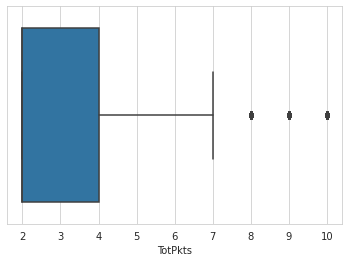

In [ ]:
sns.boxplot(ctu_data.TotPkts)

In [ ]:
ctu_data["TotBytes"] = ctu_data["TotBytes"].clip(lower = ctu_data["TotBytes"].quantile(0.15),upper = ctu_data["TotBytes"].quantile(0.85)) 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


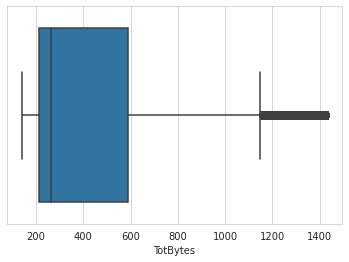

In [ ]:
sns.boxplot(ctu_data['TotBytes'])

In [ ]:
ctu_data["SrcBytes"] = ctu_data["SrcBytes"].clip(lower = ctu_data["SrcBytes"].quantile(0.15),upper = ctu_data["SrcBytes"].quantile(0.85)) 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


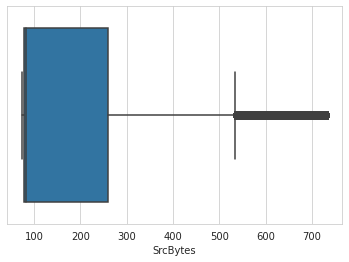

In [ ]:
sns.boxplot(ctu_data['SrcBytes'])

## Time window code

In [ ]:
print(pd.to_datetime(ctu_data['StartTime']).min())
print(pd.to_datetime(ctu_data['StartTime']).max())

2011-08-10 09:46:53.047277
2011-08-10 15:54:07.368340


In [ ]:
ctu_data['StartTime_new'] = pd.to_datetime(ctu_data['StartTime']).astype(np.int64)*(1e-9)
start_time = ctu_data['StartTime_new'].min()
start_time


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  """Entry point for launching an IPython kernel.


1312969613.0472772

In [ ]:
window_width = 120 
window_stride = 60 
ctu_data['Window_lower'] = (ctu_data['StartTime_new']-start_time-window_width)/window_stride+1
ctu_data['Window_lower'].clip(lower=0,inplace=True)
ctu_data['Window_lower']

0            0.000000
1            0.000000
2            0.000000
3            0.000000
4            0.000000
              ...    
2824631    366.238419
2824632    366.238443
2824633    366.238500
2824634    366.238659
2824635    366.238684
Name: Window_lower, Length: 2824523, dtype: float64

In [ ]:
ctu_data['Window_upper_excl'] = (ctu_data['StartTime_new']-start_time)/window_stride+1
ctu_data['Window_upper_excl'] 

0            1.000000
1            1.000026
2            1.000044
3            1.000108
4            1.000111
              ...    
2824631    368.238419
2824632    368.238443
2824633    368.238500
2824634    368.238659
2824635    368.238684
Name: Window_upper_excl, Length: 2824523, dtype: float64

In [ ]:
ctu_data.drop('StartTime',inplace=True,axis=1)
ctu_data.head()

,Dur,Proto,SrcAddr,Sport,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Final-Labels,StartTime_new,Window_lower,Window_upper_excl
0,3550.182373,udp,212.50.71.179,39678,147.32.84.229,13363,CON,0.0,0.0,12,875,413,0,1.312970e+09,0.0,1.000000
1,0.000883,udp,84.13.246.132,28431,147.32.84.229,13363,CON,0.0,0.0,2,135,75,0,1.312970e+09,0.0,1.000026
2,0.000326,tcp,217.163.21.35,80,147.32.86.194,2063,FA_A,0.0,0.0,2,120,60,0,1.312970e+09,0.0,1.000044
3,0.056966,tcp,83.3.77.74,32882,147.32.85.5,21857,FA_FA,0.0,0.0,3,180,120,0,1.312970e+09,0.0,1.000108
4,3427.768066,udp,74.89.223.204,21278,147.32.84.229,13363,CON,0.0,0.0,42,2856,1596,0,1.312970e+09,0.0,1.000111


In [ ]:
ctu_data = ctu_data.astype({"Window_lower": int, "Window_upper_excl": int})
ctu_data.drop('StartTime_new', axis=1, inplace=True)
nb_windows = ctu_data['Window_upper_excl'].max()
print(nb_windows)

368


In [ ]:
#function for normalized subgroup entropy
def RU(df):
    if df.shape[0] == 1:
        return 1.0
    else:
        proba = df.value_counts()/df.shape[0]
        h = proba*np.log10(proba)
        return -h.sum()/np.log10(df.shape[0])

In [ ]:
X = pd.DataFrame()
for i in range(0,nb_windows):       #range is supposed to be nb_windows
    gb = ctu_data.loc[(ctu_data['Window_lower'] <= i) & (ctu_data['Window_upper_excl'] > i)].groupby('SrcAddr')
    X = X.append(gb.size().to_frame(name='counts').join(gb.agg({'Sport':['nunique',RU],
                                                         #'DstAddr':['nunique',RU],
                                                          'Dport':['nunique',RU],
                                                         'Proto':['nunique',RU],
                                                         'Dur':['sum','mean','std','max','median'],
                                                         'TotPkts':['sum','mean','std','max','median'],
                                                         'SrcBytes':['sum','mean','std','max','median'],
                                                         'Final-Labels':lambda x: x.mode()[0]})).reset_index().assign(window_id=i))

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,


## SOME EDA RELATED TO TIME WINDOW





In [ ]:
X.head()

,SrcAddr,counts,"(Sport, nunique)","(Sport, RU)","(Dport, nunique)","(Dport, RU)","(Proto, nunique)","(Proto, RU)","(Dur, sum)","(Dur, mean)","(Dur, std)","(Dur, max)","(Dur, median)","(TotPkts, sum)","(TotPkts, mean)","(TotPkts, std)","(TotPkts, max)","(TotPkts, median)","(SrcBytes, sum)","(SrcBytes, mean)","(SrcBytes, std)","(SrcBytes, max)","(SrcBytes, median)","(Final-Labels, <lambda>)",window_id
0,0.0.0.0,1,1,1.0,1,1.0,1,1.0,3592.177734,3592.177734,NaN,3592.177734,3592.177734,356,356.0,NaN,356,356.0,118034,118034.0,NaN,118034,118034.0,0,0
1,1.144.156.226,1,1,1.0,1,1.0,1,1.0,0.003020,0.003020,NaN,0.003020,0.003020,2,2.0,NaN,2,2.0,73,73.0,NaN,73,73.0,0,0
2,1.144.5.55,1,1,1.0,1,1.0,1,1.0,0.002826,0.002826,NaN,0.002826,0.002826,2,2.0,NaN,2,2.0,475,475.0,NaN,475,475.0,0,0
3,1.155.150.224,1,1,1.0,1,1.0,1,1.0,0.000879,0.000879,NaN,0.000879,0.000879,2,2.0,NaN,2,2.0,74,74.0,NaN,74,74.0,0,0
4,1.161.139.96,1,1,1.0,1,1.0,1,1.0,1509.379883,1509.379883,NaN,1509.379883,1509.379883,10,10.0,NaN,10,10.0,1289,1289.0,NaN,1289,1289.0,0,0


In [ ]:
X.shape

(2226533, 27)

Aggregrations where count is not one

In [ ]:
X.loc[X.counts !=1]

,SrcAddr,counts,"(Sport, nunique)","(Sport, RU)","(DstAddr, nunique)","(DstAddr, RU)","(Dport, nunique)","(Dport, RU)","(Proto, nunique)","(Proto, RU)",...,"(TotPkts, std)","(TotPkts, max)","(TotPkts, median)","(SrcBytes, sum)","(SrcBytes, mean)","(SrcBytes, std)","(SrcBytes, max)","(SrcBytes, median)","(Final-Labels, <lambda>)",window_id
72,109.123.209.192,5,1,-0.0,1,-0.0,5,1.0,1,-0.000000,...,2.738613,9,9.0,420,84.000000,32.863353,120,60.0,0,0
87,109.149.33.116,2,1,-0.0,1,-0.0,2,1.0,1,-0.000000,...,0.000000,2,2.0,134,67.000000,9.899495,74,67.0,0,0
95,109.154.174.151,2,2,1.0,1,-0.0,1,-0.0,1,-0.000000,...,1.414214,4,3.0,192,96.000000,45.254834,128,96.0,0,0
165,109.201.184.213,4,4,1.0,1,-0.0,4,1.0,2,0.405639,...,6.500000,18,18.0,2330,582.500000,51.000000,608,608.0,0,0
173,109.205.250.34,2,2,1.0,1,-0.0,1,-0.0,1,-0.000000,...,0.000000,6,6.0,384,192.000000,0.000000,192,192.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,74.198.164.183,3,3,1.0,1,-0.0,3,1.0,1,-0.000000,...,4.041452,10,7.0,1021,340.333333,259.546399,597,346.0,0,367
469,78.122.48.25,2,2,1.0,1,-0.0,2,1.0,1,-0.000000,...,7.778175,21,15.5,1115,557.500000,301.934596,771,557.5,0,367
522,82.113.99.164,2,2,1.0,1,-0.0,2,1.0,1,-0.000000,...,5.656854,25,21.0,1874,937.000000,298.399062,1148,937.0,0,367
660,89.168.68.188,3,3,1.0,1,-0.0,3,1.0,1,-0.000000,...,3.055050,11,7.0,780,260.000000,119.146968,390,234.0,0,367


FILLING STD DEVIATION FOR THE FIELDS WITH COUNT 1 AS 0

In [ ]:
X.fillna(0,inplace=True)

In [ ]:
X.loc[X['Sport', 'nunique']!=1]

,SrcAddr,counts,"(Sport, nunique)","(DstAddr, nunique)","(Dport, nunique)","(Proto, nunique)","(Dur, sum)","(Dur, mean)","(Dur, std)","(Dur, max)",...,"(TotPkts, std)","(TotPkts, max)","(TotPkts, median)","(SrcBytes, sum)","(SrcBytes, mean)","(SrcBytes, std)","(SrcBytes, max)","(SrcBytes, median)","(Final-Labels, <lambda>)",window_id
95,109.154.174.151,2,2,1,1,1,0.385521,0.192761,0.269775,0.383520,...,1.414214,4,3.0,192,96.000000,45.254834,128,96.0,0,0
165,109.201.184.213,4,4,1,4,2,42.655637,10.663909,1.047075,11.190853,...,6.500000,18,18.0,2330,582.500000,51.000000,608,608.0,0,0
173,109.205.250.34,2,2,1,1,1,0.695249,0.347625,0.147946,0.452238,...,0.000000,6,6.0,384,192.000000,0.000000,192,192.0,0,0
178,109.214.186.117,2,2,1,1,2,251.396000,125.698000,176.124569,250.236877,...,2.828427,6,4.0,301,150.500000,61.518290,194,150.5,0,0
419,113.128.219.130,3,3,1,1,1,10438.248291,3479.416097,144.096055,3599.914551,...,11.015141,36,26.0,3282,1094.000000,232.559670,1356,1014.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5781,94.26.28.135,2,2,1,1,1,0.002072,0.001036,0.000260,0.001220,...,0.000000,2,2.0,158,79.000000,0.000000,79,79.0,0,99
5863,94.85.243.97,3,3,1,1,1,0.003207,0.001069,0.000253,0.001359,...,0.000000,2,2.0,569,189.666667,4.041452,192,192.0,0,99
5870,95.104.113.130,2,2,1,1,1,0.002674,0.001337,0.000116,0.001419,...,0.000000,2,2.0,156,78.000000,1.414214,79,78.0,0,99
5915,95.154.121.15,3,3,1,1,1,0.000462,0.000154,0.000021,0.000173,...,0.000000,2,2.0,186,62.000000,0.000000,62,62.0,0,99


In [ ]:
X['Final-Labels', '<lambda>'].value_counts()

0    2225215
2       1032
1        286
Name: (Final-Labels, <lambda>), dtype: int64

Text(0.5, 1.05, 'Pearson Correlation of All Features')

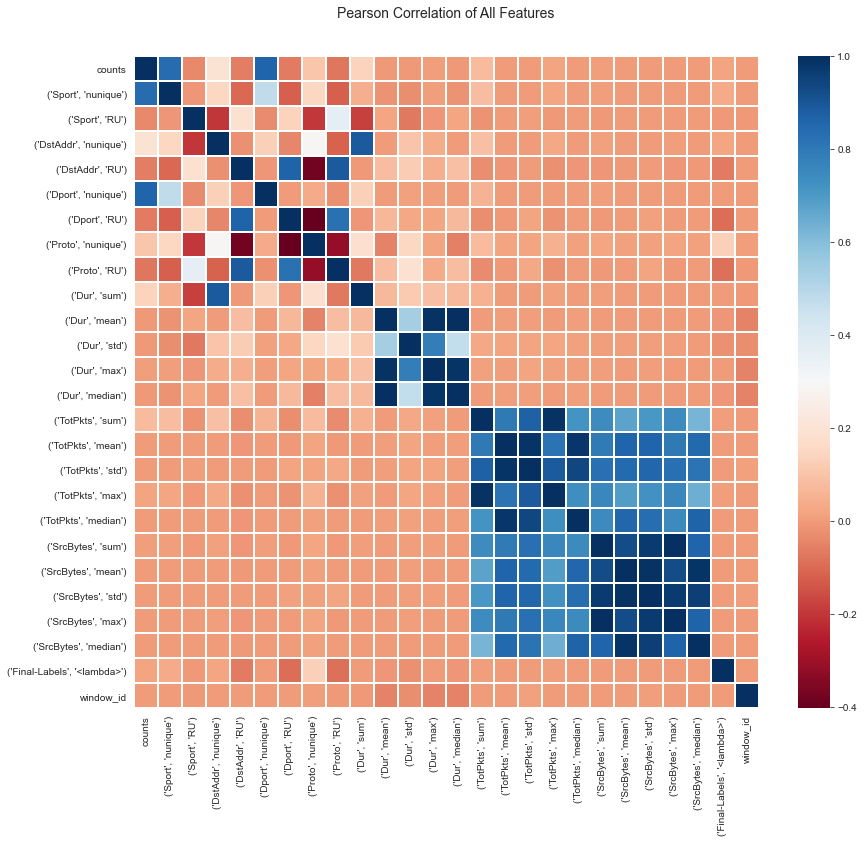

In [ ]:
plt.figure(figsize=(14,12))

# plot heatmap set the title
colormap = plt.cm.RdBu
sns.heatmap(X.corr(),linewidths=0.1,vmax=1.0, 
            square=False, cmap=colormap, linecolor='white', annot=False)
plt.title('Pearson Correlation of All Features', y=1.05, size=14)

In [ ]:
correlations = pd.DataFrame(X.corr())
correlations = pd.DataFrame(correlations['Final-Labels', '<lambda>']).reset_index()
correlations.columns = ["Feature", "Correlation with Label"]
correlations = (correlations[correlations["Feature"] != "'Final-Labels', '<lambda>'"]
                .sort_values(by="Correlation with Label", ascending=True))
display(correlations)

,Feature,Correlation with Label
6,"(Dport, RU)",-0.097747
8,"(Proto, RU)",-0.092552
4,"(DstAddr, RU)",-0.071466
11,"(Dur, std)",-0.022923
2,"(Sport, RU)",-0.017196
13,"(Dur, median)",-0.011371
10,"(Dur, mean)",-0.010590
21,"(SrcBytes, std)",-0.000702
12,"(Dur, max)",-0.000674
18,"(TotPkts, median)",-0.000111


Code for sequential Feature Selector using RF

In [ ]:
feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_jobs=-1),
           k_features=15,
           forward=False,
           verbose=2,
           scoring='roc_auc',
           cv=4)


In [ ]:
y = X['Final-Labels', '<lambda>']

In [ ]:
X1 = X.iloc[:,2:23]

In [ ]:
X.drop(['Final-Labels', '<lambda>'],inplace=True,axis=1)
#X1 = X.iloc[:,1:25]

In [ ]:
features = feature_selector.fit(X.fillna(0), y)
filtered_features= X.columns[list(features.k_feature_idx_)]
filtered_features

# Training model

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.1, random_state=1)

In [ ]:
from sklearn.metrics import accuracy_score
def fit_evaluate_model(model, X_train, y_train, X_valid, Y_valid):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    return accuracy_score(y_valid, y_predicted),y_predicted

In [ ]:
rf_classifier = RandomForestClassifier()
rf_accuracy,y_predicted = fit_evaluate_model(rf_classifier, X_train, y_train, X_valid, y_valid)
print("Number of correct predictions made out of all predictions are:", rf_accuracy)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Number of correct predictions made out of all predictions are: 0.99983382288214


Confusion Matrix and Classification Report for Random Forest 

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(y_valid, y_predicted))
print('Classification Report')
target_names = ['Background','Botnet','Foreground']
print(classification_report(y_valid, y_predicted, target_names=target_names))

Confusion Matrix
[[222520      0      5]
 [     2     27      0]
 [    30      0     70]]
Classification Report
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00    222525
      Botnet       1.00      0.93      0.96        29
  Foreground       0.93      0.70      0.80       100

    accuracy                           1.00    222654
   macro avg       0.98      0.88      0.92    222654
weighted avg       1.00      1.00      1.00    222654



Saving model parameters in a pickle file

In [ ]:
import pickle
filename = 'model_smalltest.sav'
pickle.dump(rf_classifier, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
y_pickle_pred_small = loaded_model.predict(X_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
print_results(y_valid,y_pickle_pred_small)

Confusion Matrix
[[222520      2     30]
 [     0     27      0]
 [     5      0     70]]
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00    222552
      Botnet       0.93      1.00      0.96        27
  Foreground       0.70      0.93      0.80        75

    accuracy                           1.00    222654
   macro avg       0.88      0.98      0.92    222654
weighted avg       1.00      1.00      1.00    222654



Model trained with class weights

In [ ]:
model = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample')
rf_accuracy,y_predicted = fit_evaluate_model(model, X_train, y_train, X_valid, y_valid)
print("Number of correct predictions made out of all predictions are:", rf_accuracy)


Number of correct predictions made out of all predictions are: 0.9995126957357509


In [ ]:
#predicted values
(unique, counts) = np.unique(y_predicted, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[     0, 445091],
       [     1,     49],
       [     2,    167]])

In [ ]:
#actual values
(unique, counts) = np.unique(y_valid, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[     0, 445045],
       [     1,     52],
       [     2,    210]])

Random Undersampling

In [ ]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
X_over, y_over = undersample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from collections import Counter
print(Counter(y_over))

Counter({2: 822, 0: 234, 1: 234})


In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean

steps = [('under', RandomUnderSampler()), ('model', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_micro', cv=cv, n_jobs=-1)
score = mean(scores)
print('F1 Score: %.3f' % score)

F1 Score: 0.948


Parameter tuning for random trees

In [ ]:
n_estimators = [50, 100, 300, 500, 1000]

# The minimum number of samples required to be at a leaf node, default value is 1.
min_samples_leaf = [1, 2, 4, 6, 8]

# The number of features to consider when looking for the best split, default value is auto.
max_features = ['auto', 'sqrt', 'log2', None] 

# Define the grid of hyperparameters to search
hyperparameter_grid = {'n_estimators': n_estimators,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
tuned_model = RandomForestClassifier()

# create Randomized search object
random_cv = RandomizedSearchCV(estimator=tuned_model,
                               param_distributions=hyperparameter_grid,
                               cv=5, n_iter=20, 
                               scoring = 'accuracy',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True, 
                               )
random_cv.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
random_cv.best_estimator_

In [ ]:
random_forest_tuned = 

In [ ]:
xrf_classifier = ExtraTreesClassifier()
xrf_accuracy = fit_evaluate_model(xrf_classifier, X_train, y_train, X_valid, y_valid)
print("Number of correct predictions made out of all predictions are:", xrf_accuracy)

Number of correct predictions made out of all predictions are: (0.9998113660912584, array([0, 0, 0, ..., 0, 0, 0]))


**XGB **

In [ ]:

xgb_classifier = XGBClassifier()
xgb_accuracy,y_predicted = fit_evaluate_model(xgb_classifier, X_train, y_train, X_valid, y_valid)
print("Number of correct predictions made out of all predictions are:", xgb_accuracy)

Number of correct predictions made out of all predictions are: 0.9996811188685558


In [ ]:
print('Confusion Matrix')
print(confusion_matrix(y_valid, y_predicted))
print('Classification Report')
target_names = ['Background','Botnet','Normal']
print(classification_report(y_valid, y_predicted, target_names=target_names))

Confusion Matrix
[[445029      0     16]
 [     1     51      0]
 [   125      0     85]]
Classification Report
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00    445045
      Botnet       1.00      0.98      0.99        52
      Normal       0.84      0.40      0.55       210

    accuracy                           1.00    445307
   macro avg       0.95      0.80      0.85    445307
weighted avg       1.00      1.00      1.00    445307



In [ ]:
#predicted values
(unique, counts) = np.unique(y_predicted, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[     0, 445155],
       [     1,     51],
       [     2,    101]])

In [ ]:
xgb_classifier = XGBClassifier(class_weight='balanced_subsample')
xgb_accuracy,y_predicted = fit_evaluate_model(xgb_classifier, X_train, y_train, X_valid, y_valid)
print("Number of correct predictions made out of all predictions are:", xgb_accuracy)

Number of correct predictions made out of all predictions are: 0.9996811188685558


In [ ]:
print('Confusion Matrix')
print(confusion_matrix(y_valid, y_predicted))
print('Classification Report')
target_names = ['Background','Botnet','Normal']
print(classification_report(y_valid, y_predicted, target_names=target_names))

Confusion Matrix
[[445029      0     16]
 [     1     51      0]
 [   125      0     85]]
Classification Report
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00    445045
      Botnet       1.00      0.98      0.99        52
      Normal       0.84      0.40      0.55       210

    accuracy                           1.00    445307
   macro avg       0.95      0.80      0.85    445307
weighted avg       1.00      1.00      1.00    445307



XGB **tuning**

In [ ]:
param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'n_estimators' : [100, 200, 500],
    }
xgb_model = XGBClassifier()

gsearch = GridSearchCV(estimator = xgb_model,
                        param_grid = param_tuning,                        
                        cv = 5,
                        scoring = 'accuracy',
                        n_jobs = -1,
                        return_train_score = True, 
                        verbose = 1)

gsearch.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
X_train.shape

Features importance after training 

In [ ]:
features = list(X_train.columns)

# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': features, 
                                'importance': xrf_classifier.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)
feature_results.head(10)

,feature,importance
0,"(Dur, max)",0.064229
1,"(SrcBytes, mean)",0.060402
2,"(DstAddr, RU)",0.059775
3,"(DstAddr, nunique)",0.058967
4,"(SrcBytes, max)",0.055724
5,"(SrcBytes, sum)",0.052622
6,"(Sport, nunique)",0.052213
7,"(Dur, median)",0.050590
8,"(Proto, RU)",0.049814
9,"(Dur, mean)",0.049399


# Testing model with a different dataset of botnets - Rbot and Virut

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/netflow_botnet/malware3.csv')

In [ ]:
data2 = pd.read_csv('/content/drive/MyDrive/netflow_botnet/malware43.csv')

In [ ]:
data.shape

(4710638, 15)

In [ ]:
test_df = data.iloc[:,:]

In [ ]:
test_df2 = data2.iloc[:,:]

In [ ]:
test_df.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/12 15:24:01.105063,75.532112,tcp,74.125.108.243,80,<?>,147.32.86.187,55707,FPA_FA,0.0,0.0,8107.0,1.009640e+07,10005608.0,flow=Background
1,2011/08/12 15:24:01.105402,6.650236,tcp,147.32.84.164,22,<?>,83.208.193.123,15173,FPA_FPA,0.0,0.0,33.0,3.218000e+03,1532.0,flow=From-Normal-V44-Grill
2,2011/08/12 15:24:01.106568,3599.641602,tcp,217.168.211.184,3953,<?>,147.32.84.14,22,PA_PA,0.0,0.0,1604343.0,1.585303e+09,38328160.0,flow=Background
3,2011/08/12 15:24:01.113763,1341.314453,udp,173.9.132.155,54369,<->,147.32.84.59,15046,CON,0.0,0.0,284072.0,2.434466e+08,120384296.0,flow=Background-Established-cmpgw-CVUT
4,2011/08/12 15:24:01.119062,3599.992920,tcp,88.103.40.117,37378,<?>,147.32.84.59,56306,PA_PA,0.0,0.0,229138.0,2.136376e+08,206786146.0,flow=Background-Established-cmpgw-CVUT


In [ ]:
#for virut
test_df["Final-Labels"] = test_df.Label.apply(Label_op)
test_df["Final-Labels"].value_counts()

0    4566929
2     116887
1      26822
Name: Final-Labels, dtype: int64

In [ ]:
#for Rbot
test_df2["Final-Labels"] = test_df2.Label.apply(Label_op)
test_df2["Final-Labels"].value_counts()

0    1778061
1      20941
2       9120
Name: Final-Labels, dtype: int64

In [ ]:
test_df.drop(['Label','Dir'],axis=1,inplace=True)

In [ ]:
test_df['sTos'] = test_df['sTos'].fillna(test_df['sTos'].mean())

In [ ]:
test_df['dTos'] = test_df['dTos'].fillna(test_df['dTos'].mean())

In [ ]:

test_df['Dport'].fillna(test_df.groupby('Proto')['Dport'].apply(lambda x:x.mode())[0],inplace=True)
#ctu_data['Dport'].fillna((ctu_data.groupby(['Proto','Dport'])['Dport'].agg(pd.Series.mode)))

In [ ]:
def ctu_preprocessing(df):
  #df.drop(['Label','Dir'],axis=1,inplace=True)
  df['sTos'] = df['sTos'].fillna(df['sTos'].mean())
  df['dTos'] = df['dTos'].fillna(df['dTos'].mean())
  df['Dport'].fillna(df.groupby('Proto')['Dport'].apply(lambda x:x.mode())[0],inplace=True)
  df['Sport'].fillna(df.groupby('Proto')['Sport'].apply(lambda x:x.mode())[0],inplace=True)
  df["TotPkts"] = df["TotPkts"].clip(lower = df["TotPkts"].quantile(0.15),upper = df["TotPkts"].quantile(0.85)) 
  df["TotBytes"] = df["TotBytes"].clip(lower = df["TotBytes"].quantile(0.15),upper = df["TotBytes"].quantile(0.85)) 
  df["SrcBytes"] = df["SrcBytes"].clip(lower = df["SrcBytes"].quantile(0.15),upper = df["SrcBytes"].quantile(0.85)) 
  return df

In [ ]:
test_df2 = ctu_preprocessing(test_df2)

In [ ]:
protocols_del = ['ipv6','udt','esp','pim','rarp','unas','ipx/spx']
#temp_df = ctu_data[ctu_data.Proto in protocols_del]
index = test_df2[((test_df2.Proto =='ipv6')| (test_df2.Proto =='udt')|(test_df2.Proto == 'esp') | (test_df2.Proto == 'pim')|(test_df2.Proto == 'rarp')|(test_df2.Proto == 'unas')|(test_df2.Proto =='ipx/spx')|(test_df2.Proto == 'ipv6-icmp'))].index
test_df2.drop(index,inplace=True)
test_df2.Proto.value_counts()

udp     1485660
tcp      293675
icmp      23616
rtp        2023
rtcp       1479
igmp       1241
arp         340
gre           1
Name: Proto, dtype: int64

In [ ]:
def create_nids_time_window(df):
  df['StartTime_new'] = pd.to_datetime(df['StartTime']).astype(np.int64)*(1e-9)
  start_time = df['StartTime_new'].min()
  window_width = 120
  window_stride = 60 
  df['Window_lower'] = (df['StartTime_new']-start_time-window_width)/window_stride+1
  df['Window_lower'].clip(lower=0,inplace=True)
  df['Window_upper_excl'] = (df['StartTime_new']-start_time)/window_stride+1
  df.drop('StartTime',inplace=True,axis=1)
  df = df.astype({"Window_lower": int, "Window_upper_excl": int})

  nb_windows = df['Window_upper_excl'].max()
  print(nb_windows)
  df.drop('StartTime_new', axis=1, inplace=True)
  X_nids = pd.DataFrame()
  for i in range(0,nb_windows):       #range is supposed to be nb_windows
    gb = df.loc[(df['Window_lower'] <= i) & (df['Window_upper_excl'] > i)].groupby('SrcAddr')
    X_nids = X_nids.append(gb.size().to_frame(name='counts').join(gb.agg({'Sport':['nunique',RU],
                                                         'DstAddr':['nunique',RU],
                                                          'Dport':['nunique',RU],
                                                         'Proto':['nunique',RU],
                                                         'Dur':['sum','mean','std','max','median'],
                                                         'TotPkts':['sum','mean','std','max','median'],
                                                         'SrcBytes':['sum','mean','std','max','median'],
                                                         'Final-Labels':lambda x: x.mode()[0]})).reset_index().assign(window_id=i))
  return X_nids


In [ ]:
X_test2 = pd.DataFrame()
X_test2 = create_nids_time_window(test_df2)

252


/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different leve

In [ ]:
X_test2.head()

,SrcAddr,counts,"(Sport, nunique)","(Sport, RU)","(DstAddr, nunique)","(DstAddr, RU)","(Dport, nunique)","(Dport, RU)","(Proto, nunique)","(Proto, RU)","(Dur, sum)","(Dur, mean)","(Dur, std)","(Dur, max)","(Dur, median)","(TotPkts, sum)","(TotPkts, mean)","(TotPkts, std)","(TotPkts, max)","(TotPkts, median)","(SrcBytes, sum)","(SrcBytes, mean)","(SrcBytes, std)","(SrcBytes, max)","(SrcBytes, median)","(Final-Labels, <lambda>)",window_id
0,0.0.0.0,1,1,1.0,1,1.0,1,1.0,1,1.0,3598.302246,3598.302246,NaN,3598.302246,3598.302246,10,10.0,NaN,10,10.0,831,831.0,NaN,831,831.0,0,0
1,1.152.212.181,1,1,1.0,1,1.0,1,1.0,1,1.0,2.239833,2.239833,NaN,2.239833,2.239833,8,8.0,NaN,8,8.0,831,831.0,NaN,831,831.0,0,0
2,1.152.218.104,1,1,1.0,1,1.0,1,1.0,1,1.0,0.000763,0.000763,NaN,0.000763,0.000763,2,2.0,NaN,2,2.0,76,76.0,NaN,76,76.0,0,0
3,1.152.226.38,1,1,1.0,1,1.0,1,1.0,1,1.0,14.779215,14.779215,NaN,14.779215,14.779215,10,10.0,NaN,10,10.0,450,450.0,NaN,450,450.0,0,0
4,1.168.141.44,1,1,1.0,1,1.0,1,1.0,1,1.0,3548.319092,3548.319092,NaN,3548.319092,3548.319092,10,10.0,NaN,10,10.0,831,831.0,NaN,831,831.0,0,0


In [ ]:
X_test2.iloc[:,2:25]

,"(Sport, nunique)","(Sport, RU)","(DstAddr, nunique)","(DstAddr, RU)","(Dport, nunique)","(Dport, RU)","(Proto, nunique)","(Proto, RU)","(Dur, sum)","(Dur, mean)","(Dur, std)","(Dur, max)","(Dur, median)","(TotPkts, sum)","(TotPkts, mean)","(TotPkts, std)","(TotPkts, max)","(TotPkts, median)","(SrcBytes, sum)","(SrcBytes, mean)","(SrcBytes, std)","(SrcBytes, max)","(SrcBytes, median)"
0,1,1.0,1,1.0,1,1.0,1,1.0,3598.302246,3598.302246,NaN,3598.302246,3598.302246,10,10.0,NaN,10,10.0,831,831.0,NaN,831,831.0
1,1,1.0,1,1.0,1,1.0,1,1.0,2.239833,2.239833,NaN,2.239833,2.239833,8,8.0,NaN,8,8.0,831,831.0,NaN,831,831.0
2,1,1.0,1,1.0,1,1.0,1,1.0,0.000763,0.000763,NaN,0.000763,0.000763,2,2.0,NaN,2,2.0,76,76.0,NaN,76,76.0
3,1,1.0,1,1.0,1,1.0,1,1.0,14.779215,14.779215,NaN,14.779215,14.779215,10,10.0,NaN,10,10.0,450,450.0,NaN,450,450.0
4,1,1.0,1,1.0,1,1.0,1,1.0,3548.319092,3548.319092,NaN,3548.319092,3548.319092,10,10.0,NaN,10,10.0,831,831.0,NaN,831,831.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,1,1.0,1,1.0,1,1.0,1,1.0,0.002409,0.002409,NaN,0.002409,0.002409,2,2.0,NaN,2,2.0,459,459.0,NaN,459,459.0
1021,1,1.0,1,1.0,1,1.0,1,1.0,6.052575,6.052575,NaN,6.052575,6.052575,3,3.0,NaN,3,3.0,831,831.0,NaN,831,831.0
1022,1,1.0,1,1.0,1,1.0,1,1.0,18.111736,18.111736,NaN,18.111736,18.111736,10,10.0,NaN,10,10.0,831,831.0,NaN,831,831.0
1023,1,1.0,1,1.0,1,1.0,1,1.0,0.347058,0.347058,NaN,0.347058,0.347058,4,4.0,NaN,4,4.0,177,177.0,NaN,177,177.0


In [ ]:
y_test = X_test2.iloc[:,25]
X_test = X_test2.iloc[:,2:25]

In [ ]:
test_df['Window_upper_excl'] = (test_df['StartTime_new']-start_time)/window_stride+1
test_df.drop('StartTime',inplace=True,axis=1)
test_df = test_df.astype({"Window_lower": int, "Window_upper_excl": int})
test_df.drop('StartTime_new', axis=1, inplace=True)
nb_windows = test_df['Window_upper_excl'].max()
print(nb_windows)

4010


In [ ]:
X = pd.DataFrame()
for i in range(0,nb_windows):       #range is supposed to be nb_windows
    gb = test_df.loc[(test_df['Window_lower'] <= i) & (test_df['Window_upper_excl'] > i)].groupby('SrcAddr')
    X = X.append(gb.size().to_frame(name='counts').join(gb.agg({'Sport':['nunique',RU],
                                                         'DstAddr':['nunique',RU],
                                                          'Dport':['nunique',RU],
                                                         'Proto':['nunique',RU],
                                                         'Dur':['sum','mean','std','max','median'],
                                                         'TotPkts':['sum','mean','std','max','median'],
                                                         'SrcBytes':['sum','mean','std','max','median'],
                                                         'Final-Labels':lambda x: x.mode()[0]})).reset_index().assign(window_id=i))

In [ ]:
X.head()

,SrcAddr,counts,"(Sport, nunique)","(Sport, RU)","(DstAddr, nunique)","(DstAddr, RU)","(Dport, nunique)","(Dport, RU)","(Proto, nunique)","(Proto, RU)","(Dur, sum)","(Dur, mean)","(Dur, std)","(Dur, max)","(Dur, median)","(TotPkts, sum)","(TotPkts, mean)","(TotPkts, std)","(TotPkts, max)","(TotPkts, median)","(SrcBytes, sum)","(SrcBytes, mean)","(SrcBytes, std)","(SrcBytes, max)","(SrcBytes, median)","(Final-Labels, <lambda>)",window_id
0,0.0.0.0,1,1,1.0,1,1.0,1,1.0,1,1.0,3586.215576,3586.215576,NaN,3586.215576,3586.215576,357,357.0,NaN,357,357.0,118376,118376.0,NaN,118376,118376.0,0,0
1,106.158.147.110,1,1,1.0,1,1.0,1,1.0,1,1.0,18.126289,18.126289,NaN,18.126289,18.126289,28,28.0,NaN,28,28.0,840,840.0,NaN,840,840.0,0,0
2,108.6.32.7,1,1,1.0,1,1.0,1,1.0,1,1.0,3086.968506,3086.968506,NaN,3086.968506,3086.968506,10,10.0,NaN,10,10.0,2275,2275.0,NaN,2275,2275.0,0,0
3,109.110.228.27,1,1,1.0,1,1.0,1,1.0,1,1.0,0.000363,0.000363,NaN,0.000363,0.000363,2,2.0,NaN,2,2.0,60,60.0,NaN,60,60.0,0,0
4,109.113.13.14,1,1,1.0,1,1.0,1,1.0,1,1.0,0.000345,0.000345,NaN,0.000345,0.000345,2,2.0,NaN,2,2.0,75,75.0,NaN,75,75.0,0,0


In [ ]:
y_test = X['Final-Labels', '<lambda>']
X_test = X.iloc[:,2:25]

In [ ]:
X_test.fillna(0,inplace=True)

In [ ]:
#malware 3 
y_test_predicted = model.predict(X_test)
print(accuracy_score(y_test, y_test_predicted))

 #predicted values
(unique, counts) = np.unique(y_test_predicted, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print("predicted val")
print(frequencies)

#true values



0.9995703480041442
predicted val
[[      0 1430626]
 [      1     130]
 [      2     635]]


In [ ]:
#malware3 
print('Confusion Matrix')
print(confusion_matrix(y_test, y_test_predicted))
print('Classification Report')
target_names = ['Background','Botnet','Foreground']
print(classification_report(y_test, y_test_predicted, target_names=target_names))

Confusion Matrix
[[1430406       4     391]
 [     81     126       0]
 [    139       0     244]]
Classification Report
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00   1430801
      Botnet       0.97      0.61      0.75       207
  Foreground       0.38      0.64      0.48       383

    accuracy                           1.00   1431391
   macro avg       0.78      0.75      0.74   1431391
weighted avg       1.00      1.00      1.00   1431391



In [ ]:
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[0.000000e+00, 2.225215e+06],
       [1.000000e+00, 2.860000e+02],
       [2.000000e+00, 1.032000e+03]])

In [ ]:
#for virut 
y_test_predicted = model.predict(X_test)
print(accuracy_score(y_test, y_test_predicted))

(unique, counts) = np.unique(y_test_predicted, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

0.9998872406206486
[[      0 1524460]
 [      1     173]
 [      2     739]]
[[      0 1524472]
 [      1     176]
 [      2     724]]


Virut Results

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(y_test, y_test_predicted))
print('Classification Report')
target_names = ['Background','Botnet','Foreground']
print(classification_report(y_test, y_test_predicted, target_names=target_names))

Confusion Matrix
[[1524380       0      92]
 [      3     173       0]
 [     77       0     647]]
Classification Report
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00   1524472
      Botnet       1.00      0.98      0.99       176
      Normal       0.88      0.89      0.88       724

    accuracy                           1.00   1525372
   macro avg       0.96      0.96      0.96   1525372
weighted avg       1.00      1.00      1.00   1525372

